# COMP 8610: Assignment 2

Spencer Briguglio&nbsp;103 746 720</br>
Nour Elkot&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;104 982 352</br>
Karan Vishavjit&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;110 099 867

## Question 1
### Prepare the Data

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import logging
import math
from tqdm import tqdm
from scipy.special import expit

# Set random seed
np.random.seed = 7

In [2]:
# Generate 5000 synthetic data points (x,y)
# Vector X
X_mu = 0
X_std = 1
X_ = np.random.normal(X_mu, X_std, size=(5000,1)).astype(dtype=np.float128)

# Vector Eps
eps_mu = 0
eps_std = np.sqrt(0.25)
eps_ = np.random.normal(eps_mu, eps_std, size=(5000,1)).astype(dtype=np.float128)

# Generate the Y vector
Y_ = np.zeros(shape=(1,5000), dtype=np.float128)
Y_ = -1 + (0.5 * X_) - (2 * X_**2) + (0.3 * X_**3) + eps_

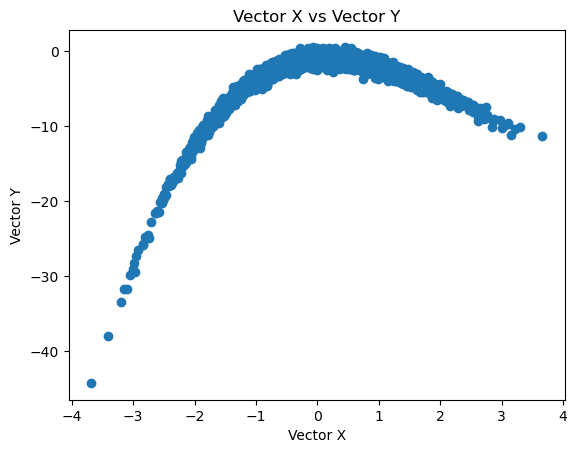

In [3]:
# Y vs X Scatterplot
plt.scatter(X_, Y_)

plt.title("Vector X vs Vector Y")
plt.xlabel("Vector X")
plt.ylabel("Vector Y")
plt.show()

## Adaline Neuron

## ISSUES
- Not as accurate at Linear Regression, but maybe this is to be expect?
- Maybe I could simplify this code? I wanted a neuron to be a class so they can be treated as object
- Sorry if you find the approach naive, EOD work is not typically my best

## Description of the Neuron
The neuron class is made to simulate the neurons learned about in class, primarily adaline and sigmoid. Only two methods are accessible outside of the class, `Neuron.fit()` and `Neuron.predict()`. The process intended is as follows:
1. Create Neuron object with desired attributes. You can choose the activation function, descent mode, set the number of predictors (dim; dimensions), learning rate and maximum number of epochs
2. Train the neuron using the `Neuron.fit()` method.</br>
The idea here is that the this method will first append a column of 1's to the sample matrix so it can by multiplied by the weight vector `Neuron.W`. Then the neuron is <i>trained</i> until a MSE stops changing or the maximum number of epochs is reached. Because various activation functions or gradient descent methods can be used, I created some utility functions to perform the correct algorithm depending on how the Neuron was initialized. So first `Neuron.__train()` calls the corrent training method, `Neuron.__train_bgd()`, or `Neuron.__train_sgd()`. In both of these methods, the prediction for $y_{hat}$ is made by called the `Neuron.__activation()` method which simply performs the weighted sum of all the inputs (stored as `v`) and then passes that weighted sum to the appropriate activation function `Neuron.__activation.adaline()` for adaline, `Neuron.__activation.sigmoid_e()` for the logisitc function, or `Neuron.__activation.adaline()` for tanh. These methods are defined within the `Neuron.__activation()` method because they are not required elsewhere and for readability.
3. Predict using the `Neuron.predict()` method.

In [4]:
# Define Neuron
class Neuron:
    def __init__(self, activation="adaline", descent_method="bgd", dim=1, learning_rate=0.001, epochs=100):
        logger = logging.getLogger(__name__)
        # Check parameters
        try:
            if (activation != "adaline"   and
                activation != "sigmoid_e" and 
                activation != "sigmoid_tanh"):
                raise ValueError("Invalid mode, \"{}\", passed to neuron class. Expected \"adaline\" or \"sigmoid_e\" or \"sigmoid_tanh\".".format(activation))
            elif descent_method != "sgd" and descent_method != "bgd":
                raise ValueError("Invalid gradient descent method, \"{}\", passed to neuron class. Expected \"sgd\" or \"sigmoid\".".format(descent_method))
            
            self.activation = activation          # Adaline OR Sigmoid (Logisitc Function) OR Sigmoid (tanh)
            self.descent_method = descent_method  # Batch/Standard Gradient Descent OR Stochastic Gradient Descent
        except ValueError as error:
            logger.error(error)
            raise
        
        # Internal
        self.dim = dim                            # Number of predictors
        self.W = np.full(shape=(self.dim, 1),
                         fill_value=0, 
                         dtype=np.float128)       # Initialize weights to small random value
        self.W_best = None                        # Weight vector from lowest MSE is saved
        self.eta = learning_rate                  # Learning rate
        self.epochs = epochs                      # Maximum number of training rounds
        self.MSE_epoch = []                       # Track MSE every epoch
        self.MSE_best = math.inf                  # Track best MSE
        
    # Private
    def __activation(self, X_i):
        # Activation Functions
        def adaline(v):
            # Yes, I could return v. I added this for readability
            y_i = v
            return y_i
    
        def sigmoid_e(v):
            # I used this scipy function because it handles overflows better
            # expit is the same a y_i = 1 / (1 + (e ** -v))
            y_i = expit(v)
            return y_i
    
        def sigmoid_tanh(v):
            y_i = math.tanh(v)
            return y_i
        
        # net input (weighted sum)
        s = self.W
        ss = X_i
        v = self.W.T @ X_i
        # From ndarray to scalar
        v = v.item()
        
        if self.activation == "adaline":
            return adaline(v=v)
        elif self.activation == "sigmoid_e":
            return sigmoid_e(v=v)
        elif self.activation == "sigmoid_tanh":
            return sigmoid_tanh(v=v)
    
    # Training and Gradient Descent
    # Batch/Standard Gradient Descent
    def __train_bgd(self, X_, Y_):
        # Initialize weight delta vector
        delta_W = np.zeros(shape = self.W.shape)
        # For each sample x_i in X_
        for i in range(X_.shape[0]):
            y_i_hat = self.__activation(X_[i])
            # For each weight vector component w_j in W
            for j in range(self.W.shape[0]):
                delta_W[j, 0] = delta_W[j, 0].item() + (self.eta * (Y_[j, 0].item() - y_i_hat) * X_[i, j].item())
        
        # For each weight vector component w_j in W
        self.W = self.W + delta_W
        for j in range(self.W.shape[0]):
            self.W[j] = self.W[j].item() + delta_W[j].item()
        #print(self.W)
        return
    
    # Stochastic/Incremental Gradient Descent
    def __train_sgd(self, X_, Y_):
        # For each sample x_i in X_
        for i in range(X_.shape[0]):
            y_i_hat = self.__activation(X_[i])
            # For each weight vector component w_j in W
            for j in range(self.W.shape[0]):
                self.W[j, 0] =  self.W[j, 0].item() + (self.eta * (Y_[j, 0].item() - y_i_hat) * X_[i, j].item())
        return
    
    # Select Training Method
    def __train(self, X_, Y_):
        if self.descent_method == "bgd":
            self.__train_bgd(X_, Y_)
            return self.__MSE(X_, Y_)
        elif self.descent_method == "sgd":
            self.__train_sgd(X_, Y_)
            return self.__MSE(X_, Y_)
    
    # Mean Squared Error
    def __MSE(self, X_, Y_):
        sum_of_error = 0
        n = X_.shape[0]
        # for every sample in X_
        for i in range(n):
            y_i_hat = self.__activation(X_[i])
            squared_error = (Y_[i, 0].item() - y_i_hat) ** 2
            sum_of_error += squared_error
        return sum_of_error / n
    
    # Public
    def fit(self, X_, Y_):
        MSE_best = math.inf
        epoch = 0
        # Until training stops or max epochs are reached
        for i in tqdm(range(self.epochs)):
            MSE = self.__train(X_, Y_)
            self.MSE_epoch.append(MSE)
            if MSE < self.MSE_best:
                self.MSE_best = MSE
                self.W_best = self.W
            epoch += 1
        print("EPOCHS: {}".format(epoch))
        # Return MSE on the training data
        return self.__MSE(X_, Y_)
    
    def predict(self, X_):
        y_pred = np.empty([X_.shape[0], 1])
        # for every sample in X_, predict y_i_hat
        for i in range(X_.shape[0]):
            y_pred[i] = self.__activation(X_[i])
        return y_pred

In [5]:
# Create data for multiple inputs
dim = 4
X_4 = X_
X_4 = np.append(np.ones((X_.shape[0], 1)), X_4, axis=1)
for i in range(2, dim):
    X_4 = np.append(X_4, X_**(i), axis=1)

In [6]:
# For sigmoid_e and sigmoid_tanh a learning rate of 0.000001 with about 100 epochs is good
# For adaline a learning rate of 0.001 t0 0.0001 is better
n = Neuron(descent_method="sgd", activation="adaline" ,dim=dim, learning_rate=0.00001, epochs=1000)

In [8]:
n.fit(X_4, Y_)

100%|██████████| 1000/1000 [01:12<00:00, 13.81it/s]

EPOCHS: 1000


5.7877324841908041895

In [9]:
n.W_best

array([[-0.54816741],
       [-0.0718062 ],
       [-1.11552293],
       [ 0.01427806]], dtype=float128)

In [10]:
n.MSE_best

5.779620831816810193

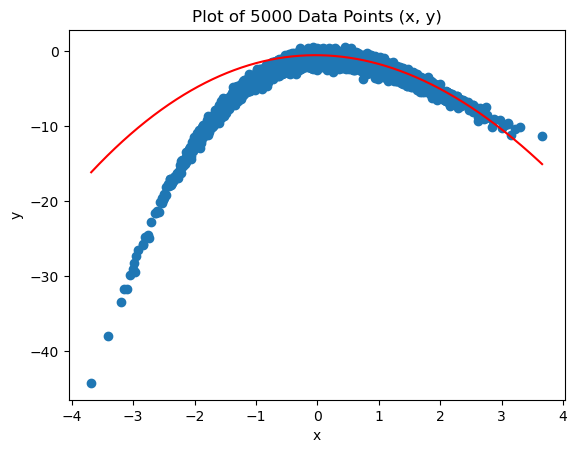

In [11]:
# Create Predictions with best W
n.W = n.W_best
y_pred = n.predict(X_4)

# Plot the model against the dataset
plt.scatter(X_, Y_)
x_line = np.linspace(np.min(X_), np.max(X_), 1000)
y_line = n.W[3]*x_line**3 + n.W[2]*x_line**2 + n.W[1]*x_line + n.W[0]
plt.plot(x_line, y_line, color='red')

plt.title("Plot of 5000 Data Points (x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [12]:
n.MSE_epoch

[16.15540426498223414,
 14.126127941678868116,
 12.53044611948280027,
 11.268165406134136844,
 10.263523588897029225,
 9.459100863399161457,
 8.811221809235925178,
 8.286512180832209362,
 7.8593326305489373583,
 7.5098698773789752535,
 7.2227169405607207033,
 6.98581560199930123,
 6.7896666343384071873,
 6.6267379236132127624,
 6.491019005563872055,
 6.37768415353704895,
 6.282836181609108619,
 6.203310481966603593,
 6.1365242028578429797,
 6.0803594174921204553,
 6.033072023173583447,
 5.9932202286088530636,
 5.959608043966557598,
 5.931240334717641477,
 5.9072868470860180243,
 5.8870532405281705795,
 5.8699576295804598205,
 5.8555114862990900585,
 5.843304016453100262,
 5.8329893203098108815,
 5.8242757988747714776,
 5.816917380982991551,
 5.8107062346280894047,
 5.8054666939526985503,
 5.801050186281912066,
 5.7973309850804545557,
 5.7942026474511260335,
 5.7915750207868983254,
 5.7893717239621899943,
 5.7875280251507696993,
 5.785989051864079398,
 5.78470827978508567,
 5.7836462559